In [1]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=6e8695c5c8349998f18c2f0e822b31043c95e011dff6439ed676f2c2e4946ba1
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55640 sha256=095c95d395dd224c3d165c2eac7a4761108358f3cc29d9ed82e8abe30e2d968d
  Stored in directory: /root/.cache/pip/wheels/12/f9/4d/ec5ad1c823c710fcc4473669fdcffc8891f4bc398c841af22e
Successfully built umap-learn pynndescent


In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import umap
from sklearn.preprocessing import StandardScaler


# plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [3]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [4]:
SAVE_GRAPH = False
GRAPH_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/EDA_20230219")

SAVE_DF = True
DF_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417")

# データ読み込み

In [5]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")
# 沖縄の月ごとの平均気温
temp = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/沖縄の月別平均気温.csv")

test.head()

,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,beach_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,306.701050,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,1421.016357,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,984.422791,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23
3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,29.648212,...,0.484109,0.270476,-0.320391,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11
4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,372.873108,...,0.440959,0.314171,-0.231658,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01


In [6]:
def _clipping_train(df, col, low_lim=0.01):
    p01 = df[col].quantile(low_lim)
    p99 = df[col].quantile(1-low_lim)
    df[col] = np.clip(df[col], p01, p99)
    return p01, p99, df

def clip_features_train(df, cols_list):
    df_clipping = pd.DataFrame(columns=["low_lim", "high_lim"])
    for col in cols_list:
        p01, p99, df = _clipping_train(df, col)
        df_clipping.loc[col] = [p01, p99]
    return df, df_clipping

def clip_features_test(df, df_df_clipping):
    cols = df_df_clipping.index.values
    low_lims = df_df_clipping["low_lim"].values
    high_lims = df_df_clipping["high_lim"].values
    for i in range(len(cols)):
        df[cols[i]] = np.clip(df[cols[i]],
                                 low_lims[i],
                                 high_lims[i])
    return df

# UMAPで次元削減

In [7]:
def plotly_scatterplot(df, x, y, hue, filename, title=""):
    cluster = sorted(df[hue].unique())
    n_cluster = len(cluster)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig = go.Figure()

    button = []
    tf = [True]*n_cluster
    tmp = dict(label="all",
               method="update",
               args=[{"visible": tf}]
               )
    button.append(tmp)

    for i,clu in enumerate(cluster):
        fig.add_trace(
            go.Scatter(
                x = df[df[hue]==clu][x],
                y = df[df[hue]==clu][y],
                opacity=0.5,
                mode="markers",
                name=str(clu),
                marker=dict(color=colors[i])
                )
            )
        tf = [False]*n_cluster
        tf[i] = True
        tmp = dict(label=clu,
                   method="update",
                   args=[{"visible": tf}]
                   )
        button.append(tmp)


    fig.update_layout(
        updatemenus=[
            dict(type="buttons",
                 x=1.15,
                 y=1,
                 buttons=button
                 )
            ])

    x_min = df[x].min()
    x_max = df[x].max()
    x_range = x_max - x_min
    y_min = df[y].min()
    y_max = df[y].max()
    y_range = y_max - y_min

    fig.update_xaxes(range=[x_min-x_range/10, x_max+x_range/10])
    fig.update_yaxes(range=[y_min-y_range/10, y_max+x_range/10])
    fig.update_layout(
    title_text=title,
    height=800,
    width=800,
    xaxis_title=x,
    yaxis_title=y,
    showlegend=False,
    )

    if SAVE_GRAPH:
        fig.write_html(GRAPH_DIR / f"{filename}.html")
    fig.show()

## 被度文献データ

In [8]:
# monthの代わりに月ごとの平均気温を入れる
temp.head()

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,1990,16.5,18.5,19.0,20.2,23.8,27.2,29.3,29.0,27.4,24.2,22.4,18.9
1,1991,17.3,16.4,20.5,22.1,24.6,28.8,29.5,28.9,27.9,24.4,21.0,19.3
2,1992,17.2,16.0,20.8,21.6,23.7,26.0,28.2,28.6,27.4,24.6,21.3,19.1
3,1993,17.4,17.0,18.3,20.7,24.6,27.0,29.1,28.9,27.5,24.9,22.8,18.8
4,1994,17.3,17.1,17.1,22.4,23.4,26.9,29.4,28.7,26.8,24.4,22.5,20.2


In [9]:
temp_mod = pd.DataFrame(columns=["date", "temp_mean"])
for month in range(1, 13):
    tmp = temp[["year", f"{month}"]]
    tmp.columns = ["date", "temp_mean"]
    tmp["date"] = (tmp["date"].astype(str) + f"{month:02}").astype(int)
    temp_mod = pd.concat((temp_mod, tmp))
temp_mod["date"] = temp_mod["date"].astype(int)
temp_mod["temp_mean"] = temp_mod["temp_mean"].astype(float)
temp_mod

,date,temp_mean
0,199001,16.5
1,199101,17.3
2,199201,17.2
3,199301,17.4
4,199401,17.3
...,...,...
28,201812,20.4
29,201912,20.0
30,202012,19.2
31,202112,18.9


In [10]:
temp_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396 entries, 0 to 32
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       396 non-null    int64  
 1   temp_mean  396 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 9.3 KB


In [11]:
def convert_int_into_str(x):
    x_str = str(int(x))
    if len(x_str)==1:
        return "0" + x_str
    return x_str

train["month_str"] = train["month"].apply(convert_int_into_str)
test["month_str"] = test["month"].apply(convert_int_into_str)

train["date"] = (train["year"].astype(int).astype(str) + train["month_str"]).astype(int)
test["date"] = (test["year"].astype(int).astype(str) + test["month_str"]).astype(int)

train = train.merge(temp_mod, on="date", how="left")
test = test.merge(temp_mod, on="date", how="left")

In [12]:
cols_umap_basic = [
    "lat",
    "lon",
    "area",
    "year",
    "temp_mean",
    "depth_original",
    "depth",
]

# とりあえず学習データだけでやる
df_umap = train[cols_umap_basic]
df_umap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14140 entries, 0 to 14139
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lat             14140 non-null  float32
 1   lon             14140 non-null  float32
 2   area            14140 non-null  float32
 3   year            14140 non-null  float32
 4   temp_mean       14140 non-null  float64
 5   depth_original  4419 non-null   float32
 6   depth           13849 non-null  float32
dtypes: float32(6), float64(1)
memory usage: 552.3 KB


In [13]:
# 欠損値を埋める
for col in cols_umap_basic:
    df_umap[col] = df_umap[col].fillna(0)

df_umap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14140 entries, 0 to 14139
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lat             14140 non-null  float32
 1   lon             14140 non-null  float32
 2   area            14140 non-null  float32
 3   year            14140 non-null  float32
 4   temp_mean       14140 non-null  float64
 5   depth_original  14140 non-null  float32
 6   depth           14140 non-null  float32
dtypes: float32(6), float64(1)
memory usage: 552.3 KB


In [14]:
# Clipping
df_umap, df_clip = clip_features_train(df_umap, cols_umap_basic)

In [15]:
# 標準化を行う
scaler = StandardScaler()
X = scaler.fit_transform(df_umap.values)

In [16]:
# https://www.kaggle.com/code/mrisdal/dimensionality-reduction-with-umap-on-mnist/notebook
model = umap.UMAP(
    n_neighbors=200,
    n_components=2,
    min_dist=0.02,
    random_state=42
    # metric='euclidean',
)

embedding = model.fit_transform(X)

df_embedded = pd.DataFrame(
    embedding,
    columns=["dim0", "dim1"]
)
df_embedded

,dim0,dim1
0,1.788618,6.597842
1,-10.111396,6.170877
2,21.165592,6.679852
3,-6.996612,9.728025
4,-6.822807,9.109682
...,...,...
14135,-1.473672,-1.401673
14136,-5.515195,7.119498
14137,11.576288,-5.339788
14138,-0.607538,17.349983


In [17]:
# テストデータ
df_umap_test = test[cols_umap_basic]
df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4039 entries, 0 to 4038
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lat             4039 non-null   float64
 1   lon             4039 non-null   float64
 2   area            4037 non-null   float64
 3   year            4039 non-null   float64
 4   temp_mean       4039 non-null   float64
 5   depth_original  1986 non-null   float64
 6   depth           4017 non-null   float64
dtypes: float64(7)
memory usage: 252.4 KB


In [18]:
# 欠損値を埋める
for col in cols_umap_basic:
    df_umap_test[col] = df_umap_test[col].fillna(0)

df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4039 entries, 0 to 4038
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lat             4039 non-null   float64
 1   lon             4039 non-null   float64
 2   area            4039 non-null   float64
 3   year            4039 non-null   float64
 4   temp_mean       4039 non-null   float64
 5   depth_original  4039 non-null   float64
 6   depth           4039 non-null   float64
dtypes: float64(7)
memory usage: 252.4 KB


In [19]:
# Clipping
df_umap_test = clip_features_test(df_umap_test, df_clip)

In [20]:
# 標準化を行う
X_test = scaler.transform(df_umap_test.values)

embedding_test = model.transform(X_test)

df_embedded_test = pd.DataFrame(
    embedding_test,
    columns=["dim0", "dim1"]
)
df_embedded_test.head()

,dim0,dim1
0,15.995628,4.112298
1,1.842246,-0.713919
2,-10.201573,11.451491
3,15.383428,9.719691
4,4.809018,-4.393333


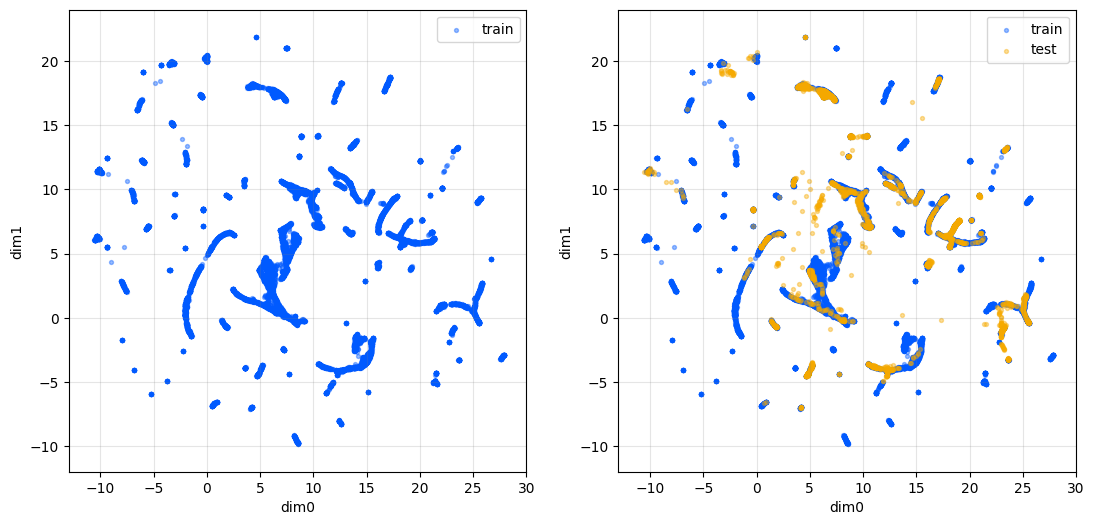

In [21]:
xlim = [
    np.floor(min(df_embedded["dim0"].min(), df_embedded_test["dim0"].min())) - 2,
    np.ceil(max(df_embedded["dim0"].max(), df_embedded_test["dim0"].max())) + 2,
]
ylim = [
    np.floor(min(df_embedded["dim1"].min(), df_embedded_test["dim1"].min())) - 2,
    np.ceil(max(df_embedded["dim1"].max(), df_embedded_test["dim1"].max())) + 2,
]

fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(121)
ax1.grid(alpha=0.2, color="gray")
ax1.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax1.set_xlabel("dim0")
ax1.set_ylabel("dim1")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.grid(alpha=0.2, color="gray")
ax2.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax2.scatter(
    df_embedded_test["dim0"],
    df_embedded_test["dim1"],
    s=8,
    alpha=0.4,
    color="#f6aa00",
    label="test"
)
ax2.set_xlabel("dim0")
ax2.set_ylabel("dim1")
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.legend()

plt.show()

In [22]:
df_embedded["cover_mod"] = "0 (cover=0)"
df_embedded.loc[train["cover"]>0, "cover_mod"] = "1 (0<cover<0.2)"
df_embedded.loc[train["cover"]>=0.2, "cover_mod"] = "2 (0.2<=cover<0.4)"
df_embedded.loc[train["cover"]>=0.4, "cover_mod"] = "3 (0.4<=cover<0.6)"
df_embedded.loc[train["cover"]>=0.6, "cover_mod"] = "4 (0.6<=cover<0.8)"
df_embedded.loc[train["cover"]>=0.8, "cover_mod"] = "5 (0.8<=cover<1)"
df_embedded.loc[train["cover"]>=1, "cover_mod"] = "6 (cover=1)"
df_embedded.head()

,dim0,dim1,cover_mod
0,1.788618,6.597842,1 (0<cover<0.2)
1,-10.111396,6.170877,4 (0.6<=cover<0.8)
2,21.165592,6.679852,1 (0<cover<0.2)
3,-6.996612,9.728025,3 (0.4<=cover<0.6)
4,-6.822807,9.109682,2 (0.2<=cover<0.4)


In [23]:
plotly_scatterplot(df_embedded, "dim0", "dim1", "cover_mod", filename="20230404_被度文献データのUMAP", title="被度文献データのUMAP")

In [24]:
if SAVE_DF:
    df_embedded.drop("cover_mod", axis=1, inplace=True)
    df_embedded["temp_monthly"] = train["temp_mean"]
    df_embedded_test["temp_monthly"] = test["temp_mean"]
    df_embedded.to_pickle(DF_DIR / "20230417_umap_basic_train.pkl")
    df_embedded_test.to_pickle(DF_DIR / "20230417_umap_basic_test.pkl")

## 海洋環境要因データ

In [25]:
cols_umap_ocean = [
    "cliff_length",
    "aicial_length",
    "beach_length",
    "coast_length",
    "coastal_dist",
    "fetch",
    "cold_sst",
    # "hist_cold_sst",
    "warm_sst",
    # "hist_warm_sst",
    # "sst_annual",
    "sst_ymd",
    # "sst_diff",
    "river_area",
    "river_dist",
    "Salinity_annual",
]

# とりあえず学習データだけでやる
df_umap = train[cols_umap_ocean]
df_umap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14140 entries, 0 to 14139
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cliff_length     13849 non-null  float32
 1   aicial_length    13849 non-null  float32
 2   beach_length     13849 non-null  float32
 3   coast_length     13849 non-null  float32
 4   coastal_dist     13849 non-null  float32
 5   fetch            13849 non-null  float32
 6   cold_sst         13849 non-null  float32
 7   warm_sst         13849 non-null  float32
 8   sst_ymd          14060 non-null  float32
 9   river_area       13849 non-null  float32
 10  river_dist       13849 non-null  float32
 11  Salinity_annual  13849 non-null  float32
dtypes: float32(12)
memory usage: 773.3 KB


In [26]:
train[df_umap["fetch"].isnull()]

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,month_str,date,temp_mean
66,24.930944,125.223694,20.0,20110619,2011.0,6.0,0.05,NaN,NaN,NaN,...,-0.792016,-2.689223,2.230381,108.170738,2.133068,-3.361164,3725_10,06,201106,27.9
113,25.827444,131.214828,20.0,20110816,2011.0,8.0,0.05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3831_20,08,201108,28.3
197,25.840721,131.269104,20.0,20110816,2011.0,8.0,0.05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3831_31,08,201108,28.3
231,25.024584,125.230804,20.0,20110927,2011.0,9.0,0.05,NaN,NaN,NaN,...,-0.831111,-2.528399,2.158718,64.224351,3.507655,-1.559795,3725_20,09,201109,27.9
240,25.868917,131.222366,20.0,20110816,2011.0,8.0,0.05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3831_30,08,201108,28.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13866,24.904667,125.324364,20.0,20110714,2011.0,7.0,0.05,NaN,NaN,NaN,...,-0.844628,-2.578560,2.128934,55.506198,2.742825,-2.359514,3725_11,07,201107,28.9
13981,25.956362,131.306641,20.0,20110815,2011.0,8.0,0.05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3831_31,08,201108,28.3
14026,25.846361,131.216721,20.0,20110816,2011.0,8.0,0.05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3831_30,08,201108,28.3
14094,25.960056,131.292557,20.0,20110815,2011.0,8.0,0.05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3831_31,08,201108,28.3


In [27]:
# 欠損値を埋める
for col in df_umap.columns:
    df_umap[col] = df_umap[col].fillna(0)
# df_umap.dropna(inplace=True)
df_umap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14140 entries, 0 to 14139
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cliff_length     14140 non-null  float32
 1   aicial_length    14140 non-null  float32
 2   beach_length     14140 non-null  float32
 3   coast_length     14140 non-null  float32
 4   coastal_dist     14140 non-null  float32
 5   fetch            14140 non-null  float32
 6   cold_sst         14140 non-null  float32
 7   warm_sst         14140 non-null  float32
 8   sst_ymd          14140 non-null  float32
 9   river_area       14140 non-null  float32
 10  river_dist       14140 non-null  float32
 11  Salinity_annual  14140 non-null  float32
dtypes: float32(12)
memory usage: 773.3 KB


In [28]:
# Clipping
df_umap, df_clip = clip_features_train(df_umap, cols_umap_ocean)

In [29]:
# 標準化を行う
scaler = StandardScaler()
X = scaler.fit_transform(df_umap.values)

In [30]:
# https://www.kaggle.com/code/mrisdal/dimensionality-reduction-with-umap-on-mnist/notebook
embedding = umap.UMAP(
    n_neighbors=200,
    n_components=2,
    min_dist=0.02,
    random_state=42
    # metric='euclidean',
).fit_transform(X)

df_embedded = pd.DataFrame(
    embedding,
    columns=["dim0", "dim1"]
)
df_embedded

,dim0,dim1
0,-5.700604,5.185160
1,2.617091,7.921879
2,10.056065,5.383829
3,11.704412,12.966528
4,12.290506,11.723819
...,...,...
14135,10.242963,9.373519
14136,15.711800,1.440546
14137,5.618413,11.349901
14138,11.571371,11.032155


In [31]:
# テストデータ
df_umap_test = test[cols_umap_ocean]
df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4039 entries, 0 to 4038
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cliff_length     4017 non-null   float64
 1   aicial_length    4017 non-null   float64
 2   beach_length     4017 non-null   float64
 3   coast_length     4017 non-null   float64
 4   coastal_dist     4017 non-null   float64
 5   fetch            4017 non-null   float64
 6   cold_sst         4017 non-null   float64
 7   warm_sst         4017 non-null   float64
 8   sst_ymd          4039 non-null   float64
 9   river_area       4017 non-null   float64
 10  river_dist       4017 non-null   float64
 11  Salinity_annual  4017 non-null   float64
dtypes: float64(12)
memory usage: 410.2 KB


In [32]:
test[df_umap_test["fetch"].isnull()]

,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,beach_length,...,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,month_str,date,temp_mean
5,24.353007,124.198957,20.0,2002.12,2002.0,12.0,0.1,NaN,NaN,NaN,...,-0.050996,2.126983,3.735545,3113.283130,-0.380021,0.310094,3624_20,12,200212,19.4
20,24.353156,124.198834,20.0,2002.12,2002.0,12.0,0.1,NaN,NaN,NaN,...,-0.052192,2.169293,3.575261,2147.918089,-0.381491,0.432860,3624_20,12,200212,19.4
123,24.353156,124.198834,20.0,2002.7,2002.0,7.0,0.1,NaN,NaN,NaN,...,-0.052192,2.169293,3.575261,2147.918089,-0.381491,0.432860,3624_20,07,200207,28.2
152,25.012667,125.281194,20.0,20110415,2011.0,4.0,NaN,NaN,NaN,NaN,...,-0.811736,-2.531539,2.039440,79.491943,3.088789,-2.945850,3725_21,04,201104,20.4
850,25.020778,125.283139,20.0,20110930,2011.0,9.0,NaN,NaN,NaN,NaN,...,-0.794389,-2.440842,2.260767,98.374926,3.813301,-5.754226,3725_21,09,201109,27.9
1217,25.020583,125.277806,20.0,20110930,2011.0,9.0,NaN,NaN,NaN,NaN,...,-0.804669,-2.329057,2.073649,87.625017,3.261631,-1.811526,3725_21,09,201109,27.9
1522,24.353007,124.198957,20.0,2002.7,2002.0,7.0,0.1,NaN,NaN,NaN,...,-0.050996,2.126983,3.735545,3113.283130,-0.380021,0.310094,3624_20,07,200207,28.2
1584,24.789296,125.378128,20.0,NaN,2019.0,10.0,0.3,NaN,NaN,NaN,...,-0.637092,-2.397476,3.083782,386.781627,2.997654,1.164343,3725_01,10,201910,26.0
1751,24.353304,124.198711,20.0,2002.7,2002.0,7.0,0.1,NaN,NaN,NaN,...,-0.005708,3.062540,3.387099,2147.918089,-0.029198,0.540612,3624_20,07,200207,28.2
1829,24.559944,124.334944,20.0,20101001,2010.0,10.0,NaN,NaN,NaN,NaN,...,-0.840744,-2.381276,2.096500,50.537536,3.624880,-5.488644,3624_31,10,201010,25.7


testに欠損値を多く含む行が22行あり。

In [33]:
# 欠損値を埋める
for col in df_umap_test.columns:
    df_umap_test[col] = df_umap_test[col].fillna(0)

# 欠損値の行削除
# df_umap_test.dropna(inplace=True)

df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4039 entries, 0 to 4038
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cliff_length     4039 non-null   float64
 1   aicial_length    4039 non-null   float64
 2   beach_length     4039 non-null   float64
 3   coast_length     4039 non-null   float64
 4   coastal_dist     4039 non-null   float64
 5   fetch            4039 non-null   float64
 6   cold_sst         4039 non-null   float64
 7   warm_sst         4039 non-null   float64
 8   sst_ymd          4039 non-null   float64
 9   river_area       4039 non-null   float64
 10  river_dist       4039 non-null   float64
 11  Salinity_annual  4039 non-null   float64
dtypes: float64(12)
memory usage: 410.2 KB


In [34]:
# Clipping
df_umap_test = clip_features_test(df_umap_test, df_clip)

In [35]:
# 標準化を行う
X_test = scaler.transform(df_umap_test.values)

embedding_test = model.transform(X_test)

df_embedded_test = pd.DataFrame(
    embedding_test,
    columns=["dim0", "dim1"]
)
df_embedded_test.head()

,dim0,dim1
0,25.659832,9.288310
1,-6.302327,16.508289
2,13.360610,6.631068
3,8.479543,-9.605115
4,8.283027,-9.439961


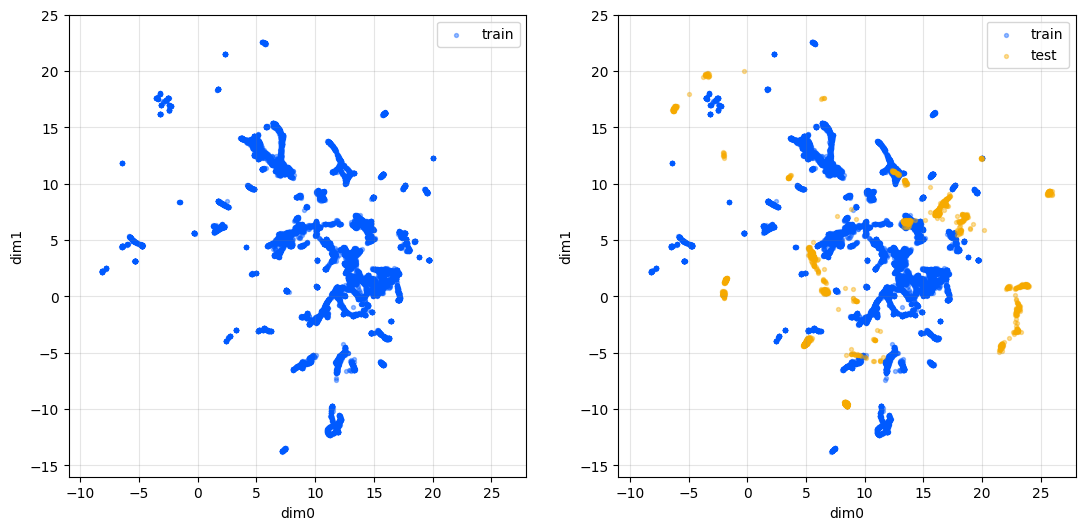

In [36]:
xlim = [
    np.floor(min(df_embedded["dim0"].min(), df_embedded_test["dim0"].min())) - 2,
    np.ceil(max(df_embedded["dim0"].max(), df_embedded_test["dim0"].max())) + 2,
]
ylim = [
    np.floor(min(df_embedded["dim1"].min(), df_embedded_test["dim1"].min())) - 2,
    np.ceil(max(df_embedded["dim1"].max(), df_embedded_test["dim1"].max())) + 2,
]

fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(121)
ax1.grid(alpha=0.2, color="gray")
ax1.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax1.set_xlabel("dim0")
ax1.set_ylabel("dim1")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.grid(alpha=0.2, color="gray")
ax2.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax2.scatter(
    df_embedded_test["dim0"],
    df_embedded_test["dim1"],
    s=8,
    alpha=0.4,
    color="#f6aa00",
    label="test"
)
ax2.set_xlabel("dim0")
ax2.set_ylabel("dim1")
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.legend()

plt.show()

In [37]:
df_embedded["cover_mod"] = "0 (cover=0)"
df_embedded.loc[train["cover"]>0, "cover_mod"] = "1 (0<cover<0.2)"
df_embedded.loc[train["cover"]>=0.2, "cover_mod"] = "2 (0.2<=cover<0.4)"
df_embedded.loc[train["cover"]>=0.4, "cover_mod"] = "3 (0.4<=cover<0.6)"
df_embedded.loc[train["cover"]>=0.6, "cover_mod"] = "4 (0.6<=cover<0.8)"
df_embedded.loc[train["cover"]>=0.8, "cover_mod"] = "5 (0.8<=cover<1)"
df_embedded.loc[train["cover"]>=1, "cover_mod"] = "6 (cover=1)"
df_embedded.head()

,dim0,dim1,cover_mod
0,-5.700604,5.185160,1 (0<cover<0.2)
1,2.617091,7.921879,4 (0.6<=cover<0.8)
2,10.056065,5.383829,1 (0<cover<0.2)
3,11.704412,12.966528,3 (0.4<=cover<0.6)
4,12.290506,11.723819,2 (0.2<=cover<0.4)


In [38]:
plotly_scatterplot(df_embedded, "dim0", "dim1", "cover_mod", filename="20230404_海洋環境要因のUMAP", title="海洋環境要因のUMAP")

In [39]:
if SAVE_DF:
    df_embedded.drop("cover_mod", axis=1, inplace=True)
    df_embedded.to_pickle(DF_DIR / "20230417_umap_marine_train.pkl")
    df_embedded_test.to_pickle(DF_DIR / "20230417_umap_marine_test.pkl")

## 被度文献＋海洋環境要因

In [40]:
cols_umap_combined = cols_umap_basic + cols_umap_ocean

# とりあえず学習データだけでやる
df_umap = train[cols_umap_combined]
df_umap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14140 entries, 0 to 14139
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              14140 non-null  float32
 1   lon              14140 non-null  float32
 2   area             14140 non-null  float32
 3   year             14140 non-null  float32
 4   temp_mean        14140 non-null  float64
 5   depth_original   4419 non-null   float32
 6   depth            13849 non-null  float32
 7   cliff_length     13849 non-null  float32
 8   aicial_length    13849 non-null  float32
 9   beach_length     13849 non-null  float32
 10  coast_length     13849 non-null  float32
 11  coastal_dist     13849 non-null  float32
 12  fetch            13849 non-null  float32
 13  cold_sst         13849 non-null  float32
 14  warm_sst         13849 non-null  float32
 15  sst_ymd          14060 non-null  float32
 16  river_area       13849 non-null  float32
 17  river_dist  

In [41]:
# 欠損値を埋める
for col in cols_umap_combined:
    df_umap[col] = df_umap[col].fillna(0)
df_umap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14140 entries, 0 to 14139
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              14140 non-null  float32
 1   lon              14140 non-null  float32
 2   area             14140 non-null  float32
 3   year             14140 non-null  float32
 4   temp_mean        14140 non-null  float64
 5   depth_original   14140 non-null  float32
 6   depth            14140 non-null  float32
 7   cliff_length     14140 non-null  float32
 8   aicial_length    14140 non-null  float32
 9   beach_length     14140 non-null  float32
 10  coast_length     14140 non-null  float32
 11  coastal_dist     14140 non-null  float32
 12  fetch            14140 non-null  float32
 13  cold_sst         14140 non-null  float32
 14  warm_sst         14140 non-null  float32
 15  sst_ymd          14140 non-null  float32
 16  river_area       14140 non-null  float32
 17  river_dist  

In [42]:
# Clipping
df_umap, df_clip = clip_features_train(df_umap, cols_umap_combined)

In [43]:
# 標準化を行う
scaler = StandardScaler()
X = scaler.fit_transform(df_umap.values)

In [44]:
# https://www.kaggle.com/code/mrisdal/dimensionality-reduction-with-umap-on-mnist/notebook
embedding = umap.UMAP(
    n_neighbors=200,
    n_components=2,
    min_dist=0.02,
    random_state=42
    # metric='euclidean',
).fit_transform(X)

df_embedded = pd.DataFrame(
    embedding,
    columns=["dim0", "dim1"]
)
df_embedded

,dim0,dim1
0,12.295664,7.637266
1,-1.609052,17.003418
2,11.879894,0.714312
3,12.517002,-10.802008
4,13.004272,-10.489010
...,...,...
14135,13.595749,-0.915732
14136,-1.642065,16.407074
14137,15.431068,6.924160
14138,14.629635,-10.150726


In [45]:
# テストデータ
df_umap_test = test[cols_umap_combined]
df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4039 entries, 0 to 4038
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              4039 non-null   float64
 1   lon              4039 non-null   float64
 2   area             4037 non-null   float64
 3   year             4039 non-null   float64
 4   temp_mean        4039 non-null   float64
 5   depth_original   1986 non-null   float64
 6   depth            4017 non-null   float64
 7   cliff_length     4017 non-null   float64
 8   aicial_length    4017 non-null   float64
 9   beach_length     4017 non-null   float64
 10  coast_length     4017 non-null   float64
 11  coastal_dist     4017 non-null   float64
 12  fetch            4017 non-null   float64
 13  cold_sst         4017 non-null   float64
 14  warm_sst         4017 non-null   float64
 15  sst_ymd          4039 non-null   float64
 16  river_area       4017 non-null   float64
 17  river_dist    

In [46]:
# 欠損値を埋める
for col in cols_umap_combined:
    df_umap_test[col] = df_umap_test[col].fillna(0)
df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4039 entries, 0 to 4038
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              4039 non-null   float64
 1   lon              4039 non-null   float64
 2   area             4039 non-null   float64
 3   year             4039 non-null   float64
 4   temp_mean        4039 non-null   float64
 5   depth_original   4039 non-null   float64
 6   depth            4039 non-null   float64
 7   cliff_length     4039 non-null   float64
 8   aicial_length    4039 non-null   float64
 9   beach_length     4039 non-null   float64
 10  coast_length     4039 non-null   float64
 11  coastal_dist     4039 non-null   float64
 12  fetch            4039 non-null   float64
 13  cold_sst         4039 non-null   float64
 14  warm_sst         4039 non-null   float64
 15  sst_ymd          4039 non-null   float64
 16  river_area       4039 non-null   float64
 17  river_dist    

In [47]:
# Clipping
df_umap_test = clip_features_test(df_umap_test, df_clip)

In [48]:
# 標準化を行う
X_test = scaler.transform(df_umap_test.values)

embedding_test = model.transform(X_test)

df_embedded_test = pd.DataFrame(
    embedding_test,
    columns=["dim0", "dim1"]
)
df_embedded_test.head()

,dim0,dim1
0,16.014555,4.112360
1,1.861547,-0.729654
2,8.485085,-0.412676
3,15.399709,9.734535
4,4.766515,-4.439975


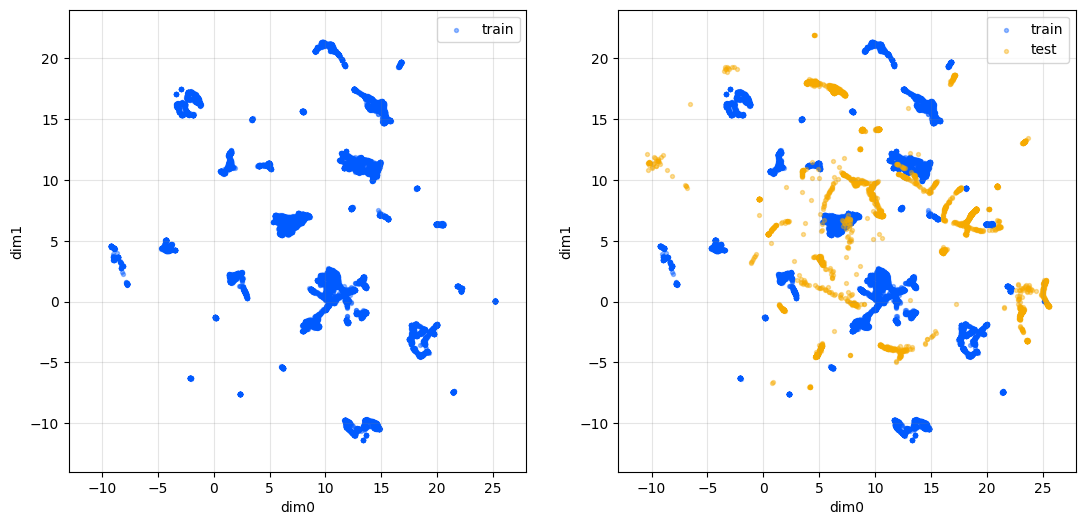

In [49]:
xlim = [
    np.floor(min(df_embedded["dim0"].min(), df_embedded_test["dim0"].min())) - 2,
    np.ceil(max(df_embedded["dim0"].max(), df_embedded_test["dim0"].max())) + 2,
]
ylim = [
    np.floor(min(df_embedded["dim1"].min(), df_embedded_test["dim1"].min())) - 2,
    np.ceil(max(df_embedded["dim1"].max(), df_embedded_test["dim1"].max())) + 2,
]

fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(121)
ax1.grid(alpha=0.2, color="gray")
ax1.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax1.set_xlabel("dim0")
ax1.set_ylabel("dim1")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.grid(alpha=0.2, color="gray")
ax2.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax2.scatter(
    df_embedded_test["dim0"],
    df_embedded_test["dim1"],
    s=8,
    alpha=0.4,
    color="#f6aa00",
    label="test"
)
ax2.set_xlabel("dim0")
ax2.set_ylabel("dim1")
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.legend()

plt.show()

In [50]:
df_embedded["cover_mod"] = "0 (cover=0)"
df_embedded.loc[train["cover"]>0, "cover_mod"] = "1 (0<cover<0.2)"
df_embedded.loc[train["cover"]>=0.2, "cover_mod"] = "2 (0.2<=cover<0.4)"
df_embedded.loc[train["cover"]>=0.4, "cover_mod"] = "3 (0.4<=cover<0.6)"
df_embedded.loc[train["cover"]>=0.6, "cover_mod"] = "4 (0.6<=cover<0.8)"
df_embedded.loc[train["cover"]>=0.8, "cover_mod"] = "5 (0.8<=cover<1)"
df_embedded.loc[train["cover"]>=1, "cover_mod"] = "6 (cover=1)"
df_embedded.head()

,dim0,dim1,cover_mod
0,12.295664,7.637266,1 (0<cover<0.2)
1,-1.609052,17.003418,4 (0.6<=cover<0.8)
2,11.879894,0.714312,1 (0<cover<0.2)
3,12.517002,-10.802008,3 (0.4<=cover<0.6)
4,13.004272,-10.489010,2 (0.2<=cover<0.4)


In [51]:
plotly_scatterplot(df_embedded, "dim0", "dim1", "cover_mod", filename="20230404_海洋環境要因のUMAP", title="海洋環境要因のUMAP")

In [52]:
if SAVE_DF:
    df_embedded.drop("cover_mod", axis=1, inplace=True)
    df_embedded.to_pickle(DF_DIR / "20230417_umap_basic_marine_train.pkl")
    df_embedded_test.to_pickle(DF_DIR / "20230417_umap_basic_marine_test.pkl")